In [2]:
import music21
import pathlib
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

从 .mid 取得音符🎵

In [5]:
midi_dir = pathlib.Path('./res/')
all_midi_files = midi_dir.glob('*.mid')

print("{} files found.".format(len(list(midi_dir.glob('*.mid')))))
all_notes = []

for i, midi_file in enumerate(all_midi_files):
    midi = music21.converter.parse(midi_file)
    midi = midi[0]

    # try:
    #     s2 = music21.instrument.partitionByInstrument(midi)
    #     notes = s2.parts[0].recurse()
    # except:
    notes = midi.flat.notes

    # 把和弦转换成 str
    for element in notes:
        if isinstance(element, music21.note.Note):
            all_notes.append(str(element.pitch))
        elif isinstance(element, music21.chord.Chord):
            all_notes.append('.'.join(str(n) for n in element.normalOrder))

    print("\r{} file(s) written.".format(i+1), end="")

with open('output/bach/all_notes', 'wb') as f:
    pickle.dump(all_notes, f)

vocab = sorted(set(all_notes))
print("\nvocab's length: ", len(vocab))
print("#notes: ", len(all_notes))
print(all_notes[:30])

2 files found.
2 file(s) written.
vocab's length:  152
#notes:  3098
['C3', 'E-3', 'G#3', 'B-3', 'C4', 'G#3', 'E-4', 'B-4', 'C5', 'G#4', 'E-5', 'B-5', 'C6', 'G5', 'B-5', 'G#5', 'G5', 'F#5', 'F#5', 'G5', 'F#5', 'F5', 'F#5', 'A5', 'G5', 'E-5', 'E-5', 'D5', 'F5', 'E-5']


In [4]:
# 建立 one-hot 词典
note_dict = {}
for i, note in enumerate(vocab):
    note_dict[note] = i

In [5]:
# 输入 100 个音符，输出之后的一个音符
input_notes_length = 100

num_training = len(all_notes) - input_notes_length
input_notes_in_vocab = np.zeros((num_training, input_notes_length, len(vocab)))
output_notes_in_vocab = np.zeros((num_training, len(vocab)))

for i in range(num_training):
    input_notes = all_notes[i: i + input_notes_length]
    output_note = all_notes[i + input_notes_length]
    for j, note in enumerate(input_notes):
        input_notes_in_vocab[i, j, note_dict[note]] = 1
    output_notes_in_vocab[i, note_dict[output_note]] = 1
    print("\r{} / {}".format(i, num_training), end="")
print()

59517 / 59518


In [6]:
model = keras.Sequential([
    keras.layers.LSTM(512, recurrent_dropout=0.3, return_sequences=True,
                      input_shape=(input_notes_length, len(vocab))),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(vocab), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [10]:
callback = keras.callbacks.ModelCheckpoint(
    filepath='output/bach/cp-{epoch:03d}.ckpt',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)
history = model.fit(input_notes_in_vocab, output_notes_in_vocab,
                    batch_size=128, epochs=200, callbacks=[callback])

Train on 59518 samples
59392/59518 [============================>.] - ETA: 2s - loss: 3.6139 - acc: 0.1493   

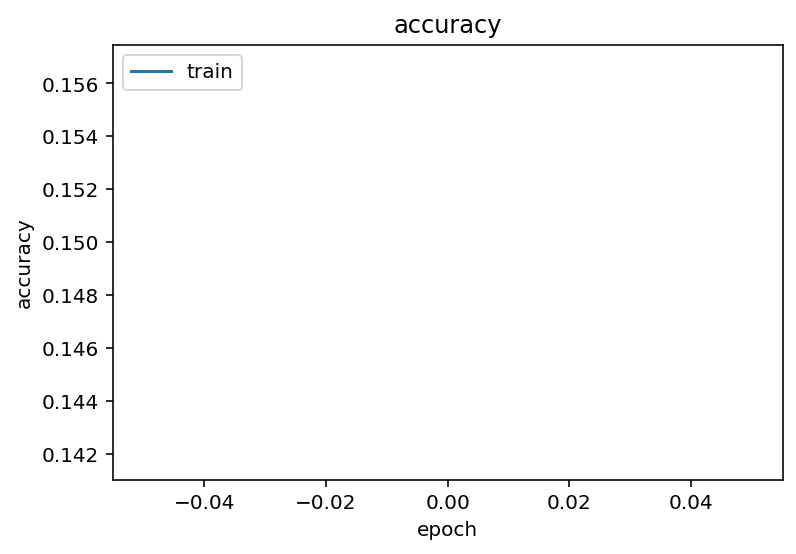

In [11]:
plt.plot(history.history['acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [12]:
model.save_weights('output/bach/weights.h5')

In [13]:
# 随机挑选一个序列作为开始
n = np.random.randint(0, len(input_notes_in_vocab) - 1)
random_sequence = input_notes_in_vocab[n]
random_sequence = random_sequence[np.newaxis, :]

In [14]:
sequence = random_sequence
outputs = []
for _ in range(100):
    newNote = model.predict(sequence, verbose=0)
    note_in_vocab = np.argmax(newNote)
    note = np.zeros((len(vocab)))
    note[note_in_vocab] = 1
    outputs.append(note)

    # 序列向前移动
    sequence = sequence[0][1:]
    sequence = np.concatenate((sequence, note[np.newaxis, :]))
    sequence = sequence[np.newaxis, :]

print(len(outputs))
print(outputs[0])

100
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


### Convert to MIDI

In [15]:
output_notes = []
for element in outputs:
    note_in_vocab = list(element).index(1)
    output_notes.append(vocab[note_in_vocab])

In [16]:
offset = 0

output_music_notes = []
for note in output_notes:
    # chord
    if ('.' in note) or note.isdigit():
        notes_in_chord = note.split('.')
        notes = []
        for note_in_chord in notes_in_chord:
            one_note = music21.note.Note(int(note_in_chord))
            one_note.storedInstrument = music21.instrument.Piano()
            notes.append(one_note)
        new_chord = music21.chord.Chord(notes)
        new_chord.offset = offset
        output_music_notes.append(new_chord)
    # note
    else:
        new_note = music21.note.Note(note)
        new_note.offset = offset
        new_note.storedInstrument = music21.instrument.Piano()
        output_music_notes.append(new_note)

    # 音符的位置 + 0.5
    offset += 0.5

midi_stream = music21.stream.Stream(output_music_notes)
midi_stream.write('midi', fp='output/bach/output.mid')

'output/output.mid'